# Preliminaries

In [ ]:
# Import general libraries
import numpy as np
import os
import PIL
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline

# Import Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Load the data using TensorFlow
train_dir = '/content/drive/MyDrive/Kaggle/training'
validation_dir = '/content/drive/MyDrive/Kaggle/validation'

img_size = 224

# Perform some data augmentation on the training set to artificially
# increase training dataset size
train_gen = ImageDataGenerator(rescale = 1./255, rotation_range = 45,
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              shear_range = 0.2,
                              zoom_range = 0.2,
                              horizontal_flip = True,
                              vertical_flip = True,
                              fill_mode = 'nearest')

train_set = train_gen.flow_from_directory(
    train_dir,
    color_mode = 'rgb',
    batch_size = 400,
    target_size = (img_size, img_size),
    class_mode = 'categorical',
    seed = 123)

# Load the validation dataset with TensorFlow

validation_gen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_gen.flow_from_directory(
    validation_dir,
    color_mode = 'rgb',
    batch_size = 99,
    target_size = (img_size, img_size),
    class_mode = 'categorical',
    seed = 123)# Load the data using TensorFlow
train_dir = '/content/drive/MyDrive/Kaggle/training'
validation_dir = '/content/drive/MyDrive/Kaggle/validation'

img_size = 224

# Perform some data augmentation on the training set to artificially
# increase training dataset size
train_gen = ImageDataGenerator(rescale = 1./255, rotation_range = 45,
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              shear_range = 0.2,
                              zoom_range = 0.2,
                              horizontal_flip = True,
                              vertical_flip = True,
                              fill_mode = 'nearest')

train_set = train_gen.flow_from_directory(
    train_dir,
    color_mode = 'rgb',
    batch_size = 400,
    target_size = (img_size, img_size),
    class_mode = 'categorical',
    seed = 123)

# Load the validation dataset with TensorFlow

validation_gen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_gen.flow_from_directory(
    validation_dir,
    color_mode = 'rgb',
    batch_size = 99,
    target_size = (img_size, img_size),
    class_mode = 'categorical',
    seed = 123)

Found 4158 images belonging to 10 classes.
Found 990 images belonging to 10 classes.


# Transfer Learning with Inception

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Define our base_model

base_model = InceptionV3(input_shape = (img_size, img_size, 3),
                         include_top = False,
                         pooling = 'avg')

for layer in base_model.layers:

    layer.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# Define our top layers

x = layers.Flatten()(base_model.output)
x = layers.Dense(128, activation = 'relu')(base_model.output)
x = layers.Dropout(0.4)(x)

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                              patience = 4, min_lr = 0.000001)

checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive', 
                             monitor = 'val_accuracy',
                             mode = 'max',
                             save_best_only = True)

stopper = EarlyStopping(monitor = 'val_loss',
                        mode = 'min',
                        patience = 4,
                        min_delta = 0.05)

# Add a final softmax layer with 10 nodes for classification
x = layers.Dense(10, activation = 'softmax')(x)

model = tf.keras.models.Model(base_model.input, x)


# Compile the model
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
inc_hist = model.fit(train_set, batch_size= 20, epochs = 50,
                     validation_data = validation_set,
                     shuffle = True, steps_per_epoch = 20,
                     validation_steps = 9, workers = 10,
                     callbacks = [reduce_lr, checkpoint, stopper],
                     use_multiprocessing = True)

Epoch 1/50
20/20 [==============================] - 448s 12s/step - loss: 2.8383 - accuracy: 0.1422 - val_loss: 2.1610 - val_accuracy: 0.2256
INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets
Epoch 2/50
20/20 [==============================] - 355s 11s/step - loss: 2.1226 - accuracy: 0.2306 - val_loss: 2.0345 - val_accuracy: 0.2671
INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets
Epoch 3/50
20/20 [==============================] - 348s 11s/step - loss: 2.0215 - accuracy: 0.2863 - val_loss: 1.9317 - val_accuracy: 0.3300
INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets
Epoch 4/50
20/20 [==============================] - 352s 10s/step - loss: 1.9147 - accuracy: 0.3249 - val_loss: 1.9192 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets
Epoch 5/50
20/20 [==============================] - 357s 11s/step - loss: 1.8463 - accuracy: 0.3570 - val_loss: 1.8997 - val_accuracy: 0.3535
INFO:tensorflow:Assets written

In [ ]:
# Save the model 
inc_saved = model.save('Inception')

INFO:tensorflow:Assets written to: Inception/assets


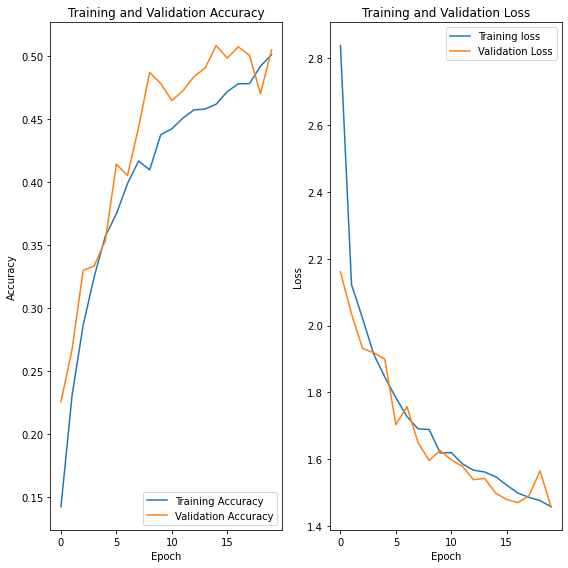

In [ ]:
# Output loss and accuracy plots 

acc = inc_hist.history['accuracy']
val_acc = inc_hist.history['val_accuracy']

loss = inc_hist.history['loss']
val_loss = inc_hist.history['val_loss']

epochs_range = range(20)

# Output graphs displaying loss vs epoch and accuracy vs epoch

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label= "Training Accuracy")
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label= "Training loss")
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")

# Save the figure
plt.savefig("FinalModelInception_loss+acc.png")

plt.tight_layout()
plt.show()

# Test Dataset

In [ ]:
from keras.preprocessing import image

def img_preprocessor(file_path):

    # Load the image
    img = image.load_img(file_path, target_size= (img_size, img_size))

    X = image.img_to_array(img)
    X = np.expand_dims(X, axis = 0)
    X_float = X.astype('float32')/255
    
    return X_float, img

In [ ]:
def art_classifier(file, artist):

    # Process the image file path

    image_file = img_preprocessor(file)

    # Display the image
    plt.imshow(image_file[1])

    # Index for given artist

    art_index = train_set.class_indices[artist]

    prediction_index = np.argmax(model.predict(image_file[0]))
    pred_prob = model.predict(image_file[0])[0][prediction_index]

    artist_val = model.predict(image_file[0])[0][art_index]
    
    return (prediction_index, pred_prob, art_index, artist_val)

(7, 0.24960655, 9, 0.036583018)

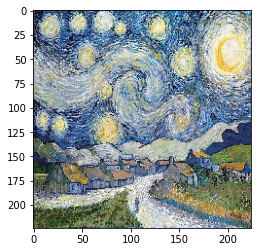

In [ ]:
art_classifier('/content/drive/MyDrive/Gogh-Fakes/Starry Night.png', 'VanGogh')

(5, 0.39511997, 5, 0.39511997)

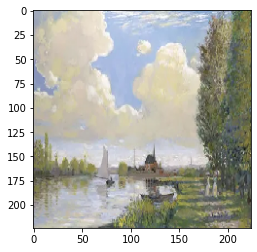

In [ ]:
art_classifier('/content/drive/MyDrive/Monet-Fakes/Summer Afternoon, Argenteuil.png', 'Monet')

(2, 0.25939465, 9, 0.04012476)

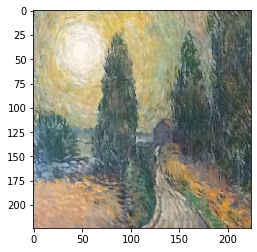

In [ ]:
art_classifier('/content/drive/MyDrive/Gogh-Fakes/Landscape near Auvers.png', 'VanGogh')